### exercise 4 selection and regularization 
### task 1 subset selection methods 

In [106]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

from tqdm import tqdm # a python package that provides progress bars for iterables
from operator import itemgetter
from itertools import combinations
from sklearn.model_selection import KFold
from matplotlib import pyplot as plt

%matplotlib inline
plt.style.use('ggplot') # emulate R's pretty plotting

# print numpy arrays with precision 4
np.set_printoptions(precision=4)

In [107]:
hitters = pd.read_csv(r'C:\Users\Chijun Zhang\Documents\jupyter\machine learning exercise\datasets\Hitters.csv',index_col=0)
hitters = hitters.dropna()
hitters.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
-Alan Ashby,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
-Alvin Davis,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
-Andre Dawson,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
-Andres Galarraga,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
-Alfredo Griffin,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A


In [108]:
dummies = pd.get_dummies(hitters[['League', 'Division', 'NewLeague']]) 
dummies.head()

,League_A,League_N,Division_E,Division_W,NewLeague_A,NewLeague_N
-Alan Ashby,0,1,0,1,0,1
-Alvin Davis,1,0,0,1,1,0
-Andre Dawson,0,1,1,0,0,1
-Andres Galarraga,0,1,1,0,0,1
-Alfredo Griffin,1,0,0,1,1,0


In [109]:
df = hitters.drop(['League', 'Division', 'NewLeague'], axis=1)
df = pd.concat([df, dummies[['League_N', 'Division_W', 'NewLeague_N']]],axis=1)
df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary,League_N,Division_W,NewLeague_N
-Alan Ashby,315,81,7,24,38,39,14,3449,835,69,321,414,375,632,43,10,475.0,1,1,1
-Alvin Davis,479,130,18,66,72,76,3,1624,457,63,224,266,263,880,82,14,480.0,0,1,0
-Andre Dawson,496,141,20,65,78,37,11,5628,1575,225,828,838,354,200,11,3,500.0,1,0,1
-Andres Galarraga,321,87,10,39,42,30,2,396,101,12,48,46,33,805,40,4,91.5,1,0,1
-Alfredo Griffin,594,169,4,74,51,35,11,4408,1133,19,501,336,194,282,421,25,750.0,0,1,0


In [110]:
def best_subsets(dataframe, predictors, response, max_features):
    
    def process_linear_model(features):
        X = sm.add_constant(dataframe[features])
        y = dataframe[response]
        
        model = sm.OLS(y,X).fit()
        RSS = model.ssr
        
        return (model, RSS)

    def get_best_kth_model(k):
        results = []
        
        for combo in combinations(predictors, k):
            results.append(process_linear_model(list(combo)))

        return sorted(results, key= itemgetter(1)).pop(0)[0]
    
    models =[]
  
    for k in tqdm(range(1,max_features+1)):
        models.append(get_best_kth_model(k))
    
    return models

In [111]:
predictors = list(df.columns)
predictors.remove('Salary')

models = best_subsets(df, predictors, ['Salary'], max_features=4)

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:16<00:00,  4.17s/it]


In [112]:
models[1].params # example 

const   -47.955902
Hits      3.300845
CRBI      0.689899
dtype: float64

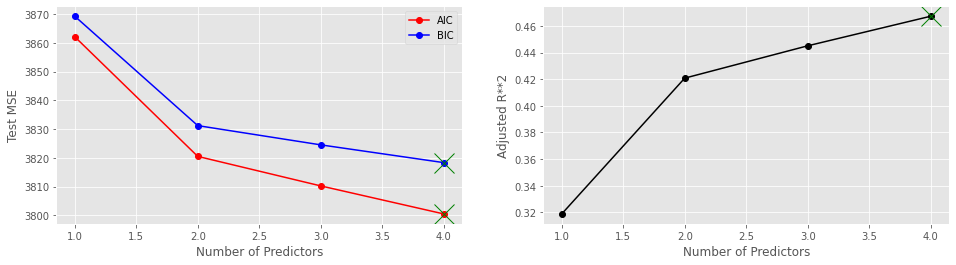

In [113]:
aics = [models[x].aic for x in range(len(models))]
bics = [models[x].bic for x in range(len(models))]
r_adj = [models[x].rsquared_adj for x in range(len(models))]

min_aic_index, min_aic = min(enumerate(aics), key=itemgetter(1))
min_bic_index, min_bic = min(enumerate(bics), key=itemgetter(1))
max_radj_index, max_radj = max(enumerate(r_adj), key=itemgetter(1))

num_predictors = np.linspace(1,len(models),len(models))

fig,(ax1, ax2) = plt.subplots(1,2,figsize=(16,4))

ax1.plot(num_predictors, aics, 'r', marker='o', label='AIC');
ax1.plot(num_predictors, bics, 'b', marker='o', label='BIC')

ax1.plot(min_aic_index+1, min_aic, 'gx', markersize=20, markeredgewidth=1)
ax1.plot(min_bic_index+1, min_bic, 'gx', markersize=20, markeredgewidth=1)

ax1.set_xlabel('Number of Predictors');
ax1.set_ylabel('Test MSE');
ax1.legend(loc='best');

ax2.plot(num_predictors, r_adj,'k', marker='o')
ax2.plot(max_radj_index+1, max_radj, 'gx', markersize=20, markeredgewidth=1)
ax2.set_xlabel('Number of Predictors');
ax2.set_ylabel('Adjusted R**2');

In [114]:
models[3].params

const          13.923104
Hits            2.675798
CRBI            0.681779
PutOuts         0.273500
Division_W   -139.953885
dtype: float64

In [115]:
def forward_step_select(df, predictors, response, max_features=len(predictors)):
    
    def process_linear_model(features):
        X = sm.add_constant(df[features])
        y = df[response]
        
        model = sm.OLS(y,X).fit()
        RSS = model.ssr

        return (model, RSS)
    
    def update_model(best_features, remaining_features):
        results = []
        
        for feature in remaining_features:
            results.append(process_linear_model(best_features + [feature]))
            
        new_model = sorted(results, key= itemgetter(1)).pop(0)[0]
        new_features = list(new_model.params.index)[1:]
        
        return new_features, new_model
    
    models = []
    best_features = []
    remaining_features = predictors
    
    while remaining_features and len(best_features) < max_features:
        
        new_features, new_model = update_model(best_features, remaining_features)
        
        best_features = new_features
        
        remaining_features =  [feature for feature in predictors if feature not in best_features]
        
        models.append((new_features,new_model))
        
    return models

In [116]:
predictors = list(df.columns)
predictors.remove('Salary')

models = forward_step_select(df,predictors,['Salary'],max_features=19)

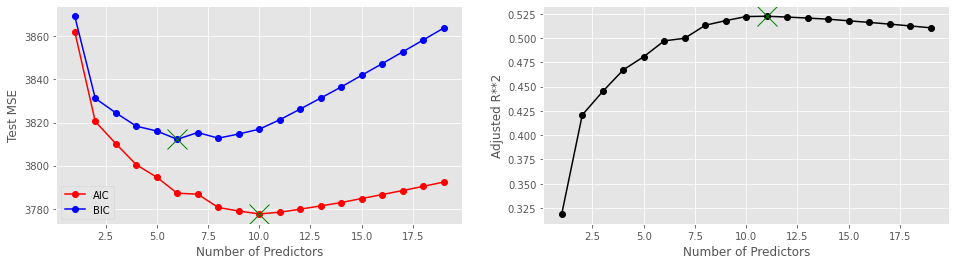

In [117]:
aics = [models[x][1].aic for x in range(len(models))]
bics = [models[x][1].bic for x in range(len(models))]
r_adj = [models[x][1].rsquared_adj for x in range(len(models))]

min_aic_index, min_aic = min(enumerate(aics), key=itemgetter(1))
min_bic_index, min_bic = min(enumerate(bics), key=itemgetter(1))
max_radj_index, max_radj = max(enumerate(r_adj), key=itemgetter(1))

num_predictors = np.linspace(1,len(models),len(models))
fig,(ax1, ax2) = plt.subplots(1,2,figsize=(16,4))
ax1.plot(num_predictors, aics, 'r', marker='o', label='AIC');
ax1.plot(num_predictors, bics, 'b', marker='o', label='BIC')

ax1.plot(min_aic_index+1, min_aic, 'gx', markersize=20, markeredgewidth=1)
ax1.plot(min_bic_index+1, min_bic, 'gx', markersize=20, markeredgewidth=1)

ax1.set_xlabel('Number of Predictors');
ax1.set_ylabel('Test MSE');
ax1.legend(loc='best');

ax2.plot(num_predictors, r_adj,'k', marker='o')
ax2.plot(max_radj_index+1, max_radj, 'gx', markersize=20, markeredgewidth=1)
ax2.set_xlabel('Number of Predictors');
ax2.set_ylabel('Adjusted R**2');

### validation

In [118]:
np.random.seed(0)
training = np.random.choice([True, False], size=len(df)) # len(df) = len(df.index)

df_train = df[training]
df_test = df[~training] # df_train + df_test = df 

In [119]:
predictors = list(df_train.columns)
predictors.remove('Salary')
models = best_subsets(df_train, predictors, ['Salary'], max_features=4)

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:16<00:00,  4.12s/it]


In [120]:
mses = np.array([])
for model in models:
    features = list(model.params.index[1:])
    
    X_test = sm.add_constant(df_test[features])
    
    salary_pred = model.predict(X_test)
    
    mses = np.append(mses, np.mean((salary_pred - df_test.Salary.values)**2))
print('MSEs =', mses)

MSEs = [197453.6869 174455.6938 171032.0227 157148.6279]


In [121]:
min_index, min_mse = min(enumerate(mses), key=itemgetter(1))
print(min_index, min_mse)

3 157148.62790931837


In [122]:
print('4 Variable Model:', list(models[3].params.index))

4 Variable Model: ['const', 'Hits', 'CHmRun', 'CRuns', 'PutOuts']


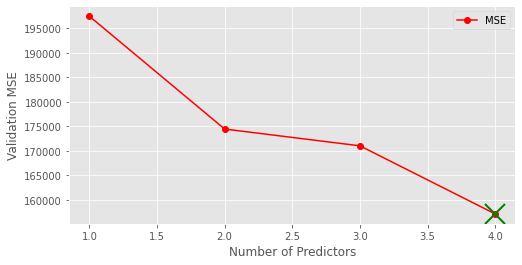

In [123]:
num_predictors = np.linspace(1,len(models),len(models))

fig, ax1 = plt.subplots(figsize=(8,4));

ax1.plot(num_predictors, mses, 'r', marker='o', label='MSE')
ax1.plot(min_index+1, min_mse, 'gx', markersize=20, markeredgewidth=2)

ax1.set_xlabel('Number of Predictors');
ax1.set_ylabel('Validation MSE');
ax1.legend(loc='best');

In [124]:
predictors = list(df.columns)
predictors.remove('Salary')
models = best_subsets(df, predictors, ['Salary'], max_features=4)

print(models[3].params)

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:18<00:00,  4.52s/it]

const          13.923104
Hits            2.675798
CRBI            0.681779
PutOuts         0.273500
Division_W   -139.953885
dtype: float64
